<div class = "alert alert-block alert-info">
    <b> Przetwarzanie multimediów. Proste systemy CBIR (content-based image retrieval) </b>
   
FTiMS, semestr letni 2022/2023

Laboratorium 8
</div>

### Zapoznaj się z ...

Zapoznaj się z treścią niniejszego notebooka. Wykonaj kod i przeanalizuj wyniki.

### Uwaga

1. Celem zadania jest konstrukcja prostego systemu tematycznego (semantycznego) wyszukiwania obrazów. Proces realizowany przez tego typu systemy składa się z dwóch głównych elementów (temat omawiany na jednym z wykładów):
- reprezentacja każdego z obrazów poprzez wektor cech (*feature vector*)
-wyznaczenie odległości (lub podobieństwa) pomiędzy obrazami oraz wybór obrazu najbardziej podobnego do obrazu zadanego. Obrazem najbardziej podobnym jest obraz maksymalizujący podobieństwo lub minimalizujący odległość.

Każdy z dwóch powyższych punktów można realizować na wiele różnych, równoważnych sposobów. Oznacza to, że w ogólności nie można powiedzieć jakie konkretne wielkości związane z obrazem mają stanowić jego wektor cech oraz jakie miary odległości (podobieństwa) należy przyjąć.

W ramach niniejszego zadania przyjmiemy następujące założenia:
- wektorem cech każdego obrazu będzie histogram takiego obrazu po wcześniejszej kwantyzacji skalarnej (usunięcie szumu informacyjnego)
- miarą odległości (podobieństwa) będą miary euklidesowa oraz manhattan (*city-block*), przy czym: mała odległość obrazów --> wysokie podobieństwo, duża odległość --> niskie podobieństwo.

2. Przedstawiony w niniejszym notebooku kod odpowiada za wyznaczenie odległości pomiędzy trzema przykładowymi obrazami. Celem zadania (opisanie poniżej) jest uogólnienie na przypadek wielu obrazów.

3. **Zadanie do rozwiązania jest umieszczone na końcu notebooka.**

## Schemat funkcjonowania systemów CBIR

Całe zagadnienie redukujemy do odpowiedzi na konkretne i uproszczone pytanie: *który z **dwóch** obrazów jest najbardziej podobny do obrazu wejściowego?* W tym celu potrzebujemy **trzech** obrazów, gdzie jeden z nich będzie pełnił rolę obrazu wejściowego (*query image*, czyli tego obrazu dla którego najbardziej podobnych szukamy), a dwa pozostałe rolę zbioru obrazów, w których proces wyszukiwania będzie wykonywany. Dla ułatwienia przyjmiemy, że w zbiorze takich trzech obrazów tylko dwa są tematycznie podobne (ta sama kategoria tematyczna).

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [88]:
img1 = plt.imread(r'./image.orig/300.jpg')
img2 = plt.imread(r'./image.orig/301.jpg')
img3 = plt.imread(r'./image.orig/257.jpg')

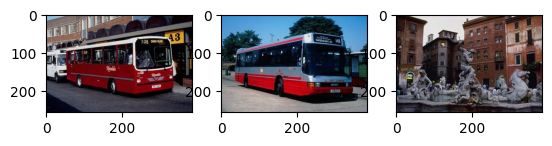

In [89]:
plt.subplot(1,3,1)
plt.imshow(img1)
plt.subplot(1,3,2)
plt.imshow(img2)
plt.subplot(1,3,3)
plt.imshow(img3)

Kwantyzacja skalarna. Stosujemy kwantyzację do 4 wartości na każdy z kanałów barwnych. Wybór 4 wartości jest arbitralny. Można testować z innymi wartościami tego parametru. Należy jednak pamiętać, że większe wartości parametru powodują powiększanie wymiaru przestrzeni, w której zdefiniowane są wektory cech oraz wydłużanie obliczeń.

In [90]:
img1q = np.floor(img1/64).astype(int)
img2q = np.floor(img2/64).astype(int)
img3q = np.floor(img3/64).astype(int)

Sprawdzamy, czy faktycznie w obrazie skwantyzowanym pojawiają się wyłącznie 4 wartości.

In [91]:
np.unique(img1q)

array([0, 1, 2, 3])

Spłaszczamy (flatten) obrazy, tak aby łatwiej je przetwarzać.

In [92]:
img1q = img1q.reshape(img1q.shape[0]*img1q.shape[1],3)
img2q = img2q.reshape(img2q.shape[0]*img2q.shape[1],3)
img3q = img3q.reshape(img3q.shape[0]*img3q.shape[1],3)

Konstruujemy wektory cech (histogramy):

In [93]:
hist = {(i,j,k):0 for i in range(0,4) for j in range(0,4) for k in range(0,4)}

In [94]:
wektory_cech = []
for imgX in [img1q, img2q, img3q]:
    h = hist.copy()
    for i in range(0,len(imgX)):
        h[imgX[i][0], imgX[i][1], imgX[i][2]] += 1
    wektory_cech.append(list(h.values()))

Uzyskane histogramy trzech obrazów:

In [95]:
print(wektory_cech[0]), print(wektory_cech[1]), print(wektory_cech[2]);

[37008, 4441, 0, 0, 18, 711, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13012, 1426, 0, 0, 473, 19240, 1045, 0, 0, 28, 427, 0, 0, 0, 0, 0, 2005, 43, 0, 0, 250, 4240, 181, 0, 21, 642, 4648, 526, 0, 0, 43, 476, 0, 1, 0, 0, 18, 44, 15, 0, 501, 214, 620, 43, 0, 12, 248, 5684]
[36228, 3198, 0, 0, 470, 3257, 801, 15, 0, 0, 36, 3076, 0, 0, 0, 0, 1713, 68, 0, 0, 27, 3502, 3539, 0, 0, 8, 1918, 15352, 0, 0, 0, 6, 3215, 177, 0, 0, 53, 969, 568, 0, 0, 62, 15279, 980, 0, 0, 0, 250, 1802, 79, 0, 0, 4, 48, 24, 0, 0, 13, 817, 9, 0, 0, 37, 704]
[34050, 1560, 0, 0, 31, 330, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13226, 443, 0, 0, 3765, 19587, 2286, 0, 0, 13, 422, 0, 0, 0, 0, 0, 3, 0, 0, 0, 573, 4004, 506, 0, 7, 714, 8537, 119, 0, 0, 11, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 770, 36, 0, 30, 94, 7153]


Na tym etapie każdy obraz jest reprezentowany swoim wektorem cech. *Wierzymy*, że jest to wektor adekwatny do treści obrazu. W praktyce stosuje się bardziej wyrafinowane metody reprezentacji treści. 
Wyznaczmy podobieństwo obrazu nr 1 do dwóch pozostałych:

In [96]:
from scipy.spatial.distance import euclidean, cityblock

In [97]:
for i in range(0,3):
    d = euclidean(wektory_cech[0],wektory_cech[i])
    print('Odleglość <obraz_1; obraz_'+str(i+1)+'> = '+str(d))

Odleglość <obraz_1; obraz_1> = 0.0
Odleglość <obraz_1; obraz_2> = 28193.6425457939
Odleglość <obraz_1; obraz_3> = 7278.817074222981


W tym przypadku można wysnuć następujący wniosek: **najbardziej podobnym obrazem do obrazu nr 1 jest obraz nr 2 ze względu na minimalną odległość wektorów cech tych obrazów**.

Wniosek nie zmienia się po zastosowaniu odległości mannhattan:

In [98]:
for i in range(0,3):
    d = cityblock(wektory_cech[0],wektory_cech[i])
    print('Odleglość <obraz_1; obraz_'+str(i+1)+'> = '+str(d))

Odleglość <obraz_1; obraz_1> = 0
Odleglość <obraz_1; obraz_2> = 82350
Odleglość <obraz_1; obraz_3> = 22706


Koniec przykładu

<div class = "alert alert-block alert-warning">
<b> Zadanie (3 punkty) </b> Korzystając z logiki wyżej zbuduj prosty system wyszukiwania obrazów (CBIR),  w którym dla każdego obrazu wzorca zostanie przypisana lista 5 obrazów najbardziej podobnych według przyjętej miary odleglości: Manhattan oraz Euklidesa.    

    
Wykorzystaj podzbiór 100 obrazów z oryginalnego zbioru 1000 obrazów dostępnego pod adresem http://wang.ist.psu.edu/docs/related/. Swój zbiór skonstruuj poprzez wybranie 10 pierwszych obrazów z każdej kategorii tematycznej, tzn. obrazy nr 0..10 (kategoria 1), 100..110 (kategoria 2), 200..210 (kategoria 3), ..., 900..910 (kategoria 10).
    
Wskazówka: po wyznaczeniu wektora cech (histogram) dla każdego obrazu wyznacz kwadratową macierz odległości, gdzie $ij$-ty element takiej macierzy reprezentuje odległość obrazu $i$ do obrazu $j$. Wyszukanie obrazów najbardziej podobnych do obrazu $i$-tego sprowadzać się wówczas będzie do przejrzenia wiersza $i$ takiej macierzy w poszukiwaniu minimalnych elementów macierzowych. Uwaga na elementy diagonalne, które są równe zero (odległość obrazu do samego siebie) - takie elementy nas nie interesują.    
    
Jako wynik (rozwiązanie) zadania przedstaw: pełny kod *.ipynnb realizujący zadanie oraz listy 5 najbardziej podobnych obrazów dla 5 obrazów przykładowych (wklej screenshoty do notebooka lub wynik przedstaw w załączonym dokumencie PDF). Wyniki przedstaw niezależnie dla odległości manhattan oraz euklidesowej.
</div>

*tu umieść swoje rozwiązanie*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean, cityblock
import glob
from pathlib import Path

In [2]:
# read all of the images as a dictonary {image_name (stem), np.array from the image}
images = {(Path(file).stem):plt.imread(file) for file in glob.glob('./image.orig/*.jpg')}

In [3]:
# scalar quantization (for each of the channels, rgb) and flatten the images
images_qf = {(name):(np.floor(images[name]/64).astype(int)).reshape(images[name].shape[0]*images[name].shape[1],3) for name in images}

In [16]:
# feature vectors as histograms
hist_base = {(i,j,k):0 for i in range(0,4) for j in range(0,4) for k in range(0,4)}
print(hist_base)

{(0, 0, 0): 0, (0, 0, 1): 0, (0, 0, 2): 0, (0, 0, 3): 0, (0, 1, 0): 0, (0, 1, 1): 0, (0, 1, 2): 0, (0, 1, 3): 0, (0, 2, 0): 0, (0, 2, 1): 0, (0, 2, 2): 0, (0, 2, 3): 0, (0, 3, 0): 0, (0, 3, 1): 0, (0, 3, 2): 0, (0, 3, 3): 0, (1, 0, 0): 0, (1, 0, 1): 0, (1, 0, 2): 0, (1, 0, 3): 0, (1, 1, 0): 0, (1, 1, 1): 0, (1, 1, 2): 0, (1, 1, 3): 0, (1, 2, 0): 0, (1, 2, 1): 0, (1, 2, 2): 0, (1, 2, 3): 0, (1, 3, 0): 0, (1, 3, 1): 0, (1, 3, 2): 0, (1, 3, 3): 0, (2, 0, 0): 0, (2, 0, 1): 0, (2, 0, 2): 0, (2, 0, 3): 0, (2, 1, 0): 0, (2, 1, 1): 0, (2, 1, 2): 0, (2, 1, 3): 0, (2, 2, 0): 0, (2, 2, 1): 0, (2, 2, 2): 0, (2, 2, 3): 0, (2, 3, 0): 0, (2, 3, 1): 0, (2, 3, 2): 0, (2, 3, 3): 0, (3, 0, 0): 0, (3, 0, 1): 0, (3, 0, 2): 0, (3, 0, 3): 0, (3, 1, 0): 0, (3, 1, 1): 0, (3, 1, 2): 0, (3, 1, 3): 0, (3, 2, 0): 0, (3, 2, 1): 0, (3, 2, 2): 0, (3, 2, 3): 0, (3, 3, 0): 0, (3, 3, 1): 0, (3, 3, 2): 0, (3, 3, 3): 0}


In [29]:
feature_vectors = {}
for name in images_qf:
    hist_copy = hist_base.copy()
    for rgb in images_qf[name]:
        hist_copy[tuple(rgb)] += 1
    feature_vectors[name] = hist_copy.values()

In [81]:
# matrix of euclidean distances
euclidean_distances = {} # {reference image name, {to image name, distance}}, skip the same images, sort in regard for rising distance
for name in feature_vectors:
    adjacent_images = {}
    for adjacent_name in feature_vectors:
        if name == adjacent_name:
            continue
        adjacent_images[adjacent_name] = euclidean(list(feature_vectors[name]),list(feature_vectors[adjacent_name]))
    euclidean_distances[name] = dict(sorted(adjacent_images.items(), key=lambda item: item[1]))

In [82]:
# matrix of cityblock (Manhattan) distances
cityblock_distances = {} # {reference image name, {to image name, distance}}, skip the same images, sort in regard for rising distance
for name in feature_vectors:
    adjacent_images = {}
    for adjacent_name in feature_vectors:
        if name == adjacent_name:
            continue
        adjacent_images[adjacent_name] = cityblock(list(feature_vectors[name]),list(feature_vectors[adjacent_name]))
    cityblock_distances[name] = dict(sorted(adjacent_images.items(), key=lambda item: item[1]))

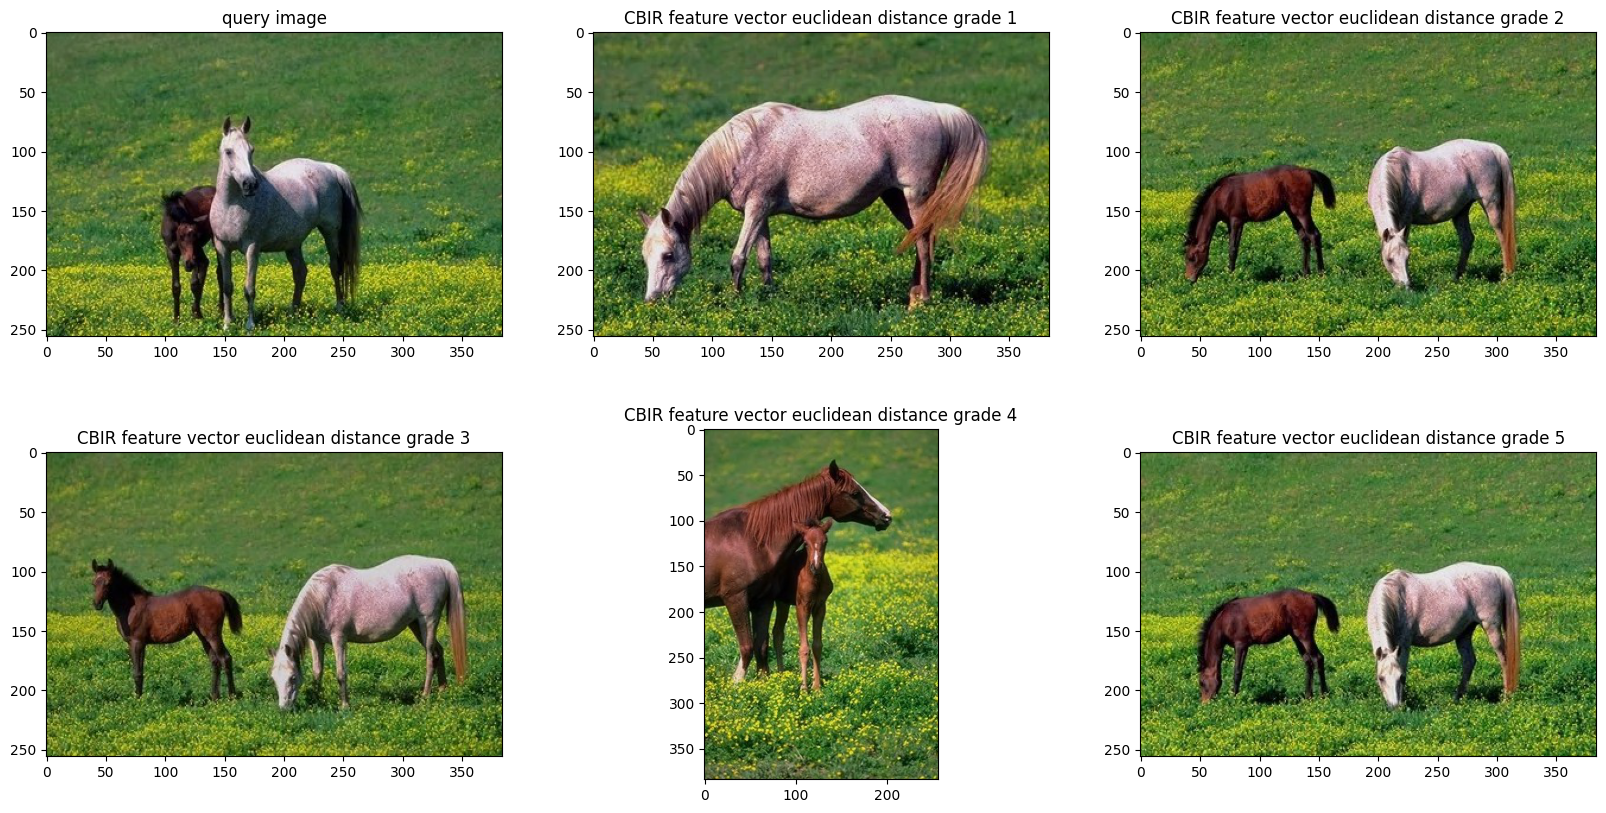

In [155]:
# CBIR euclidean
image_name = str(750)
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.title('query image')
plt.imshow(images[image_name])
i = 2
for key in euclidean_distances[image_name]:
    plt.subplot(2,3,i)
    plt.title('CBIR feature vector euclidean distance grade '+str(i-1))
    plt.imshow(images[key])
    i += 1
    if(i==7):
        break

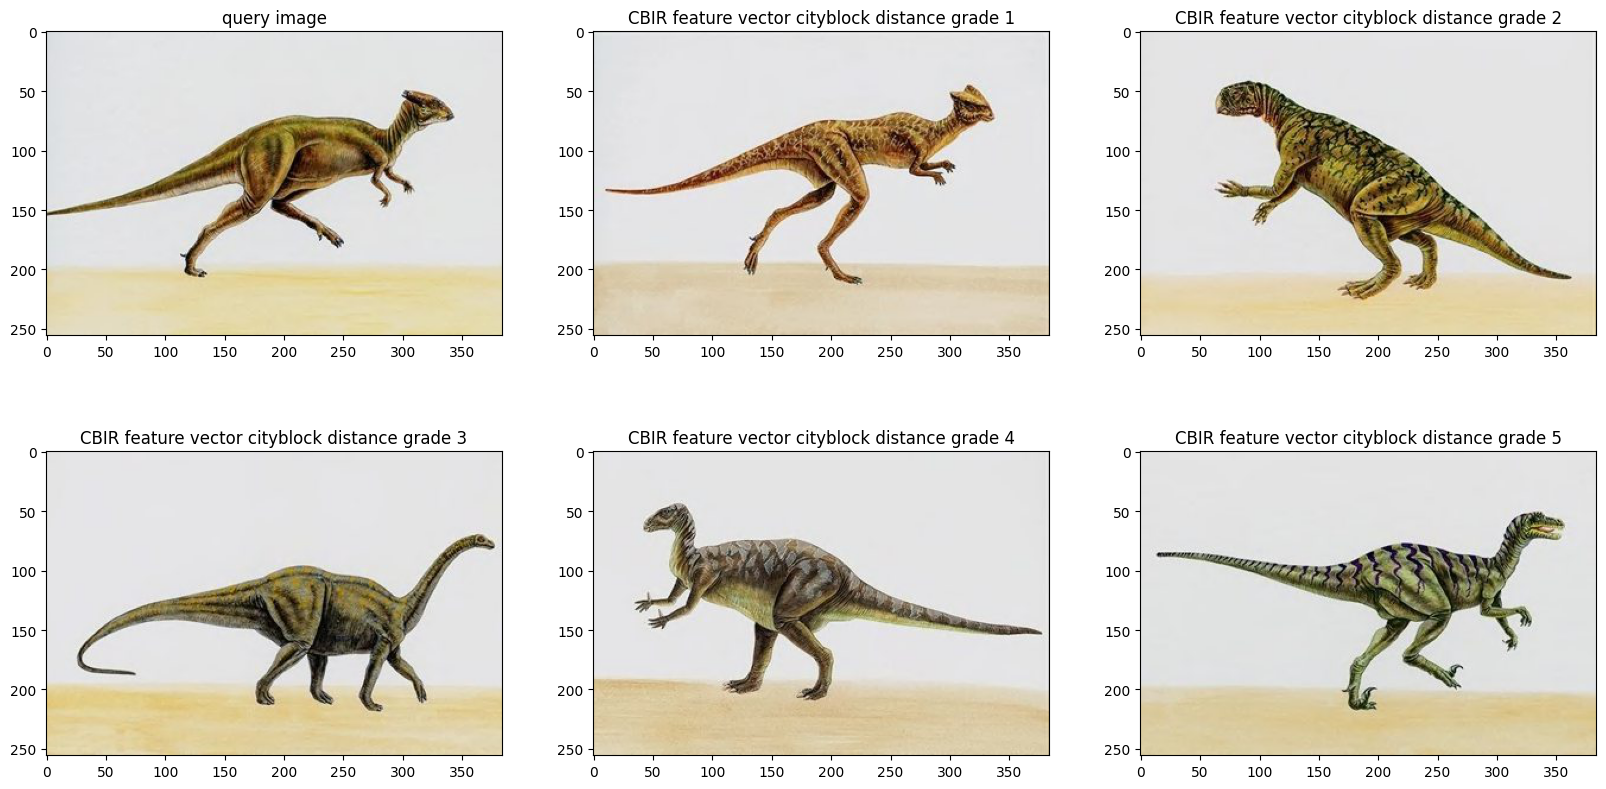

In [159]:
# CBIR cityblock
image_name = str(450)
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.title('query image')
plt.imshow(images[image_name])
i = 2
for key in cityblock_distances[image_name]:
    plt.subplot(2,3,i)
    plt.title('CBIR feature vector cityblock distance grade '+str(i-1))
    plt.imshow(images[key])
    i += 1
    if(i==7):
        break